In [25]:
import pandas as pd
import tensorflow as tf
import keras as ks
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

from sklearn.metrics import recall_score, confusion_matrix
from scripts.model_functions import *
from scripts.helper_functions import *
from sklearn.preprocessing import MinMaxScaler
from keras.optimizers import RMSprop
from keras.models import Sequential
from keras.layers import Dense, Dropout, Conv1D, Flatten, Activation

In [26]:
# Create new variables to be used in Keras and the CNN

# number of items to use for training
BATCH_SIZE = 400 

# number of times to repeat process
EPOCHS = 100

In [27]:
# Load the data
df = pd.read_csv('../../data/cleaned/site1_vineyard.csv')
df.head()

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),Chlorophyll (ug/L),Chlorophyll RFU,ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,4.4,1.3,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,4.2,1.2,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,4.3,1.3,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,4.5,1.3,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,4.5,1.3,89.8,9.02,0.4


In [28]:
target = df['BGA-Phycocyanin RFU'].apply(lambda x : x/0.2334)
dataset = df.drop(columns=['Chlorophyll (ug/L)', 'Chlorophyll RFU'])
dataset.head(5)

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4


In [29]:
from datetime import datetime

timestamp = dataset['Date (mm.dd.yyyy)'] + ' '+ dataset['Time 24hr']
timestamp = pd.to_datetime(timestamp)
dataset['Timestamp'] = timestamp
dataset.head()
#converts the date object to a numerical representation of that object
#dataset['date (mm.dd.yyyy)'] = (dataset['date (mm.dd.yyyy)'] - dataset['date (mm.dd.yyyy)'].min()) / np.timedelta64(1,'D')
#dataset.dtypes

,Date (mm.dd.yyyy),Time 24hr,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,Timestamp
0,5/5/2017,0:00,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
1,5/5/2017,0:15,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2,5/5/2017,0:30,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
3,5/5/2017,0:45,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
4,5/5/2017,1:00,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00


In [30]:
# dont need data and time now that we have Timestamp. Lets remove them

dataset = dataset.drop(columns=['Date (mm.dd.yyyy)', 'Time 24hr'])
dataset.head(10)

,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA-Phycocyanin RFU,Timestamp
0,15.02,1848,-100.1,8.36,16.84,90.2,9.04,0.4,2017-05-05 00:00:00
1,14.99,1847,-100.1,8.36,16.76,90.2,9.04,0.4,2017-05-05 00:15:00
2,14.96,1847,-100.1,8.36,16.82,90.1,9.04,0.4,2017-05-05 00:30:00
3,14.95,1848,-100.1,8.36,17.19,90.0,9.03,0.4,2017-05-05 00:45:00
4,14.92,1848,-100.0,8.36,16.85,89.8,9.02,0.4,2017-05-05 01:00:00
5,14.92,1850,-100.1,8.36,16.43,89.8,9.02,0.4,2017-05-05 01:15:00
6,14.90,1851,-100.1,8.36,16.35,89.7,9.01,0.4,2017-05-05 01:30:00
7,14.88,1852,-100.0,8.36,16.40,89.6,9.00,0.4,2017-05-05 01:45:00
8,14.84,1850,-99.9,8.36,16.82,89.4,8.99,0.4,2017-05-05 02:00:00
9,14.83,1851,-100.0,8.36,16.50,89.4,8.99,0.4,2017-05-05 02:15:00


In [31]:
# lets try to normalize this now....
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)']
scaler = MinMaxScaler()
ds_scaled = scaler.fit_transform(dataset[dataset_columns])
dataset = pd.DataFrame(ds_scaled,columns=dataset_columns)
dataset['BGA (ug/L)'] = target
dataset.describe()

C:\Users\Public\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)


,Temp C,Sp Cond (uS/cm),pH (mV),pH,Turbidity (NTU),ODOSat%,ODO (mg/L),BGA (ug/L)
count,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000,18947.000000
mean,0.560516,0.893366,0.477889,0.541089,0.090355,0.165126,0.273546,4.196706
std,0.267413,0.070246,0.116241,0.113254,0.085879,0.093899,0.116220,3.133775
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.308195,0.853771,0.426166,0.461538,0.045893,0.117086,0.190000,2.142245
50%,0.640366,0.895882,0.492228,0.553846,0.065216,0.138870,0.264545,3.856041
75%,0.784656,0.956502,0.538860,0.592308,0.102407,0.177672,0.370909,5.141388
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,68.980291


In [32]:
dataset['BGA (ug/L)'] = target
dataset_columns = ['Temp C','Sp Cond (uS/cm)', 'pH (mV)','pH', 'Turbidity (NTU)', 'ODOSat%','ODO (mg/L)']
print(type(dataset))
(segments, labels) = segment_dataset(dataset, dataset_columns , 'BGA (ug/L)', 7, pts_ahead=1)
print('done')

<class 'pandas.core.frame.DataFrame'>
WINDOW SIZE 7
NUMBER OF COULUMNS 7
             Temp C  Sp Cond (uS/cm)       pH (mV)            pH  \
count  18947.000000     18947.000000  18947.000000  18947.000000   
mean       0.560516         0.893366      0.477889      0.541089   
std        0.267413         0.070246      0.116241      0.113254   
min        0.000000         0.000000      0.000000      0.000000   
25%        0.308195         0.853771      0.426166      0.461538   
50%        0.640366         0.895882      0.492228      0.553846   
75%        0.784656         0.956502      0.538860      0.592308   
max        1.000000         1.000000      1.000000      1.000000   

       Turbidity (NTU)       ODOSat%    ODO (mg/L)    BGA (ug/L)  
count     18947.000000  18947.000000  18947.000000  18947.000000  
mean          0.090355      0.165126      0.273546      4.196706  
std           0.085879      0.093899      0.116220      3.133775  
min           0.000000      0.000000      0.00

In [33]:
print("Before (18940, 7, 7)")
print("After {}".format(segments.shape))

segments.shape

Before (18940, 7, 7)
After (18939, 7, 7)


(18939, 7, 7)

In [34]:
print("Before (18940,)")
print("After {}".format(labels.shape))
labels.shape

Before (18940,)
After (18939,)


(18939,)

In [35]:
labels

array([1.71379606, 1.71379606, 1.71379606, ..., 5.14138817, 5.14138817,
       5.14138817])

## Shaping the data to be used in the model.

In [36]:
segments = segments.reshape(len(segments),7,7)
segments.shape

(18939, 7, 7)

In [37]:
print(segments[0])

[[0.40932868 0.8537714  0.69430052 0.33076923 0.02543865 0.18652144
  0.35181818]
 [0.40802092 0.85330865 0.69430052 0.33076923 0.02531287 0.18652144
  0.35181818]
 [0.40671316 0.85330865 0.69430052 0.33076923 0.02540721 0.18584071
  0.35181818]
 [0.40627724 0.8537714  0.69430052 0.33076923 0.02598893 0.18515997
  0.35090909]
 [0.40496949 0.8537714  0.69559585 0.33076923 0.02545437 0.1837985
  0.35      ]
 [0.40496949 0.8546969  0.69430052 0.33076923 0.02479404 0.1837985
  0.35      ]
 [0.40409765 0.85515965 0.69430052 0.33076923 0.02466826 0.18311777
  0.34909091]]


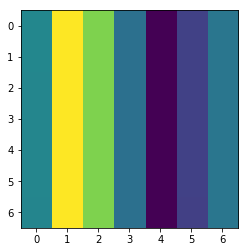

In [38]:
plt.imshow(segments[0])

## Breaking apart training and test data

In [39]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(segments, labels, test_size=0.25)

In [40]:
print("x_train shape:",x_train.shape)
print("x_test shape:",x_test.shape)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)


x_train shape: (14204, 7, 7)
x_test shape: (4735, 7, 7)
y_train shape: (14204,)
y_test shape: (4735,)


In [41]:
y_train = y_train.reshape(len(y_train),1)
y_test = y_test.reshape(len(y_test),1)
print("y_train shape:",y_train.shape)
print("y_test shape:",y_test.shape)

y_train shape: (14204, 1)
y_test shape: (4735, 1)


In [42]:
# Gets the precision of the different metrics
def create_class_predictions(pred):
    retval = np.array([])
    for row in pred:
        max_value = (-1,-1)
        for index, value in enumerate(row):
            if value > max_value[1]:
                max_value = (index, value)
        retval = np.append(retval, max_value[0])
    return retval

## Build the model

In [46]:

model = Sequential()
model.add(Conv1D(40,kernel_size=(4),input_shape=(7,7)))
model.add(Dense(40))
model.add(Dropout(0.2))
model.add(Dense(20))
model.add(Flatten())
model.add(Dense(1))
model.compile(loss='mean_squared_error',
              optimizer='rmsprop',
              metrics=['mse']
             )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_3 (Conv1D)            (None, 4, 40)             1160      
_________________________________________________________________
dense_9 (Dense)              (None, 4, 40)             1640      
_________________________________________________________________
dropout_5 (Dropout)          (None, 4, 40)             0         
_________________________________________________________________
dense_10 (Dense)             (None, 4, 20)             820       
_________________________________________________________________
flatten_3 (Flatten)          (None, 80)                0         
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 81        
Total params: 3,701
Trainable params: 3,701
Non-trainable params: 0
_________________________________________________________________


In [47]:
print(y_test[0])

[3.42759212]


In [48]:
model.fit(x=x_train, y=y_train, batch_size=BATCH_SIZE, epochs=EPOCHS, verbose=1)
# What is our score?
score = model.evaluate(x_test, y_test, verbose=1)
print("Loss {} Accuracy {}".format(score[0], score[1]))

Epoch 1/100
14204/14204 [==============================] - 1s 43us/step - loss: 11.1619 - mean_squared_error: 11.1619
Epoch 2/100
14204/14204 [==============================] - 0s 10us/step - loss: 7.6331 - mean_squared_error: 7.6331
Epoch 3/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.9161 - mean_squared_error: 6.9161
Epoch 4/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.8576 - mean_squared_error: 6.8576
Epoch 5/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.7966 - mean_squared_error: 6.7966
Epoch 6/100
14204/14204 [==============================] - 0s 9us/step - loss: 6.8409 - mean_squared_error: 6.8409
Epoch 7/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.7946 - mean_squared_error: 6.7946
Epoch 8/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.7797 - mean_squared_error: 6.7797
Epoch 9/100
14204/14204 [==============================] - 0s 10us/step

14204/14204 [==============================] - 0s 11us/step - loss: 6.4510 - mean_squared_error: 6.4510
Epoch 71/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.4582 - mean_squared_error: 6.4582
Epoch 72/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.4540 - mean_squared_error: 6.4540
Epoch 73/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.4968 - mean_squared_error: 6.4968
Epoch 74/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.4874 - mean_squared_error: 6.4874
Epoch 75/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.4396 - mean_squared_error: 6.4396
Epoch 76/100
14204/14204 [==============================] - 0s 11us/step - loss: 6.4553 - mean_squared_error: 6.4553
Epoch 77/100
14204/14204 [==============================] - 0s 10us/step - loss: 6.4734 - mean_squared_error: 6.4734
Epoch 78/100
14204/14204 [==============================] - 0s 10us/step - lo